In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)

In [12]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

In [13]:
ref_df = pd.read_csv('../../data/dataset.csv')

In [14]:
print(len(pd.unique(ref_df["Player_id"])))
print(len(pd.unique(ref_df["Club_id"])))
print(sorted(list(pd.unique(ref_df.Season))))
print(sorted(list(pd.unique(ref_df.MarketValue))))

23635
4454
[2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
[0, 10000, 12500, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 70000, 75000, 80000, 90000, 100000, 115000, 120000, 125000, 130000, 135000, 150000, 175000, 180000, 190000, 200000, 215000, 220000, 225000, 230000, 250000, 275000, 285000, 290000, 295000, 300000, 315000, 325000, 330000, 340000, 350000, 375000, 380000, 400000, 425000, 450000, 475000, 500000, 525000, 530000, 550000, 560000, 570000, 575000, 600000, 625000, 650000, 675000, 680000, 690000, 700000, 725000, 750000, 760000, 775000, 780000, 785000, 800000, 825000, 830000, 850000, 875000, 885000, 900000, 920000, 925000, 950000, 975000, 1000000, 1050000, 1075000, 1100000, 1150000, 1175000, 1200000, 1250000, 1300000, 1350000, 1375000, 1400000, 1425000, 1450000, 1500000, 1550000, 1600000, 1610000, 1625000, 1650000, 1700000, 1750000, 1800000, 1850000, 1875000, 1900000, 1950000, 2000000, 2050000, 2

In [15]:
df = pd.read_csv('../../data/dataset.csv')
df = df.sort_values(by=['Season', 'Player_id'])
categorical_features = ['Club_id', 'Competition', 'Liga', 'Liga_level', 'international']
df[categorical_features] = df[categorical_features].astype('category')

# and drop the name column (becasue it cant handle strings that are not categorical)
df = df.drop(columns=['name']) 
df = df.query('MarketValue > 0.1')  # Only include those with value above 0.1

In [16]:
# load model
model = CatBoostRegressor()
model.load_model('catboost_model_test21.cbm')


In [17]:
test = df[df['Season'] == 2021]
x_test = test.drop(['MarketValue'], axis=1)  # All but marketvalue column
y_test = test['MarketValue']  # Only marketvalue column
test = test.reset_index()  # Reset the index values
test_model = model.predict(x_test)  
test_model = 10**test_model -1  # Convert from log-scale to "normal" scale 


def predictedMV(tm_id, df=test, round=True):
    """
    Input: player ID as noted on Transfermarkt/Kaggle dataset
    Output: Estimated marketValue for the player by our model 
    """
    player_idx = df.index[df['Player_id'] == tm_id].tolist()[0]
    
    # Get the estimated value:
    retVal = test_model[player_idx]
    if round:
        return retVal.astype(int)
    else:
        return retVal

In [18]:
new_df = pd.DataFrame(columns=["Player_id", "MarketValue_by_model", "MarketValue_by_Transfermarkt"])

for id in set(test["Player_id"]):  # The column contains non-unique player_ids due to duplication
    new_df = pd.concat(
        [
        new_df,
        pd.Series(
        {'Player_id':id, 
          'MarketValue_by_model':predictedMV(id, df=test), 
          'MarketValue_by_Transfermarkt':test.loc[test["Player_id"] == id, "MarketValue"].values[0]}
        ).to_frame().T
        ], ignore_index=True
    )

new_df["relativeMV"] = new_df.MarketValue_by_model/new_df.MarketValue_by_Transfermarkt


In [23]:
# np.log(new_df["MarketValue_by_Transfermarkt"])

In [35]:
new_df["MarketValue_category"] = np.log10(new_df.MarketValue_by_Transfermarkt.astype(float)).astype(int)
new_df["MV_log2"] = np.log2(new_df.relativeMV.astype(float))
new_df["absDifference"] = (new_df.MarketValue_by_model-new_df.MarketValue_by_Transfermarkt)/new_df.MarketValue_by_Transfermarkt

In [32]:
new_df.head()

,Player_id,MarketValue_by_model,MarketValue_by_Transfermarkt,relativeMV,MarketValue_category,MV_log2,absDifference
0,393217,347135,400000,0.867838,5,-0.204503,-0.132162
1,524290,656432,400000,1.64108,5,0.714646,0.64108
2,131075,4066481,4000000,1.01662,6,0.023781,0.01662
3,360451,438073,400000,1.095182,5,0.131171,0.095183
4,786436,1234608,1500000,0.823072,6,-0.280909,-0.176928


In [26]:
new_df.query("MarketValue_category == 4").describe()
new_df

,Player_id,MarketValue_by_model,MarketValue_by_Transfermarkt,relativeMV,MarketValue_category
0,393217,347135,400000,0.867838,5
1,524290,656432,400000,1.64108,5
2,131075,4066481,4000000,1.01662,6
3,360451,438073,400000,1.095182,5
4,786436,1234608,1500000,0.823072,6
...,...,...,...,...,...
14233,294894,2953301,2000000,1.476651,6
14234,294895,391398,400000,0.978495,5
14235,458734,274984,1000000,0.274984,6
14236,65521,1811459,2000000,0.905729,6


<AxesSubplot: xlabel='MarketValue_category', ylabel='relativeMV'>

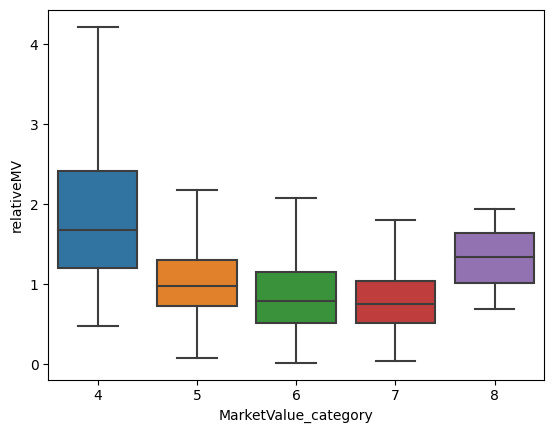

In [40]:
sns.boxplot(data=new_df, y="relativeMV", x="MarketValue_category", showfliers=False)

<AxesSubplot: xlabel='MarketValue_category', ylabel='MV_log2'>

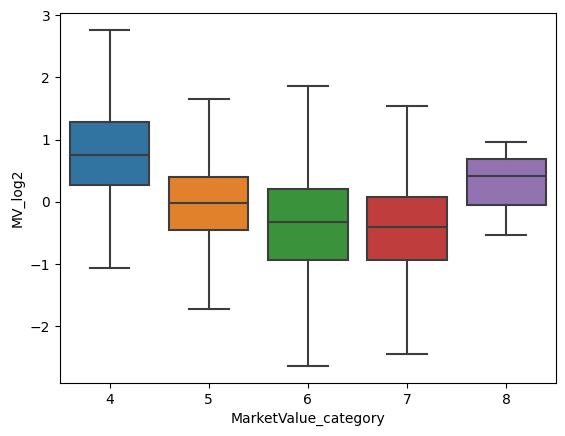

In [42]:
sns.boxplot(data=new_df, y="MV_log2", x="MarketValue_category", showfliers=False)

In [46]:
set(np.log10(list(set(new_df.MarketValue_by_Transfermarkt))).astype(int))

{4, 5, 6, 7, 8}

In [53]:
def relativeMV(tmId, tDf=test, refDf=ref_df, testSeason=2021):
    mvByModel = predictedMV(tm_id=tmId, df=test)
    mvByTransfM = tDf.loc[tDf["Player_id"] == 241641, "MarketValue"].values[0]
    # mvByTransfM = ref_df.loc[(ref_df["Player_id"] == 241641) & (ref_df["Season"] == 2021), "MarketValue"].values[0]
    return mvByModel/mvByTransfM

new_df = pd.DataFrame(columns=[])
for id in ref_df.Player_id:
    try:
        print(relativeMV(id))
    except:
        continue


0.0122824375
0.002533675
0.004315275
0.0024841875
0.3268185875
0.002533675
0.004315275
0.0024841875
0.314057275
0.0024841875
0.0054202125
0.314057275
0.010461525
0.0024841875
0.3268185875
0.0054202125
0.314057275
0.0265553125
0.0015749
0.0058055375
0.0012606
0.004994675
0.0265553125
0.0074354625
0.0015749
0.0058055375
0.0012606
0.004994675
0.0021051625
0.0265553125
0.004163675
0.0058055375
0.0012606
0.050185875
0.001211125
0.0021051625
0.2534104625
0.0026786875
0.0422350375
0.0265553125
0.004163675
0.0058055375
0.003742425
0.001211125
0.383351675
0.0021051625
0.2534104625
0.0026786875
0.1260525375
0.0422350375
0.0265553125
0.004163675
0.0058055375
0.003742425
0.383351675
0.0900591375
0.023876325
0.0021051625
0.007300475
0.2534104625
0.1260525375
0.0422350375
0.0805894625
0.448365325
0.004554
0.003955325
0.003955325
0.00430105
0.0134993125
0.014194475
0.00430105
0.0134993125
0.0053060625
0.0627556375
0.014194475
0.0721901625
0.0035984875
0.041664325
0.00280795
0.010316925
0.012347625
0.

In [48]:
ref_df.loc[(ref_df["Player_id"] == 241641) & (ref_df["Season"] == 2021), "MarketValue"].values[0]
# ref_df[(ref_df["Player_id"] == 241641) & (ref_df["Season"] == 2021)]

80000000

In [49]:
TM_id = 241641
print(f"""
Player: {TM_id}, MV: {ref_df.loc[(ref_df["Player_id"] == 241641) & (ref_df["Season"] == 2021), "MarketValue"].values[0]}, etstMV: {predictedMV(TM_id)}
""")


Player: 241641, MV: 80000000, etstMV: 88618739



In [ ]:
# Find index
test.index[test['Player_id'] == 241641].tolist()[0]



test_model[4986]




In [91]:
df.head()

,Player_id,Season,Games,PPG,Goals,Assists,Yellow_cards,Yellow_red_cards,Red_cards,Penalty_goals,Minutes_per_goal,Minutes_played,Club_id,Competition,MarketValue,name,age,Days_injured,international,Liga,Liga_level,W,D,L,Points,Goales_scored,Goales_conceded
0,10,2004,45,1.60,17,11,4,0,0,0,110.0,3244,86,Bundesliga,12000000,Miroslav Klose,26.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
1,690,2004,41,1.80,19,14,5,0,0,0,136.0,3001,86,Bundesliga,7500000,Ivan Klasnic,24.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
2,4316,2004,35,1.74,1,0,2,0,0,0,478.0,2985,86,Bundesliga,4500000,Petri Pasanen,24.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
3,4403,2004,28,1.82,3,6,4,0,0,0,130.0,1898,86,Bundesliga,4000000,Daniel Jensen,25.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
4,10,2005,40,1.70,31,17,5,1,0,1,115.0,3313,86,Bundesliga,30000000,Miroslav Klose,27.0,0.0,1,Bundesliga,First Tier,21,7,6,70,79,37


In [93]:
# define categorical features
categorical_features = ['Club_id', 'Competition', 'Liga_level']
df[categorical_features] = df[categorical_features].astype('category')

# and drop the name column (becasue it cant handle strings that are not categorical)
df = df.drop(columns=['name', 'Liga', 'Yellow_cards', 'Red_cards', 'Yellow_red_cards', 'Penalty_goals', "Minutes_per_goal"])
df = df.query('MarketValue > 0.1')

df['Goals_per_90'] = df['Goals'] / (df['Minutes_played']/90)
df.head()

,Player_id,Season,Games,PPG,Goals,Assists,Minutes_played,Club_id,Competition,MarketValue,age,Days_injured,international,Liga_level,W,D,L,Points,Goales_scored,Goales_conceded,Goals_per_90
0,10,2004,45,1.60,17,11,3244,86,Bundesliga,12000000,26.0,0.0,1,First Tier,18,5,11,59,68,37,0.471640
1,690,2004,41,1.80,19,14,3001,86,Bundesliga,7500000,24.0,0.0,1,First Tier,18,5,11,59,68,37,0.569810
2,4316,2004,35,1.74,1,0,2985,86,Bundesliga,4500000,24.0,0.0,1,First Tier,18,5,11,59,68,37,0.030151
3,4403,2004,28,1.82,3,6,1898,86,Bundesliga,4000000,25.0,0.0,1,First Tier,18,5,11,59,68,37,0.142255
4,10,2005,40,1.70,31,17,3313,86,Bundesliga,30000000,27.0,0.0,1,First Tier,21,7,6,70,79,37,0.842137


In [94]:
# split data into train and test, train is every season before 2022
train = df[df['Season'] < 2022]
test = df[df['Season'] == 2022]

x_train = train.drop(['MarketValue'], axis=1)
y_train = train['MarketValue']
x_test = test.drop(['MarketValue'], axis=1)
y_test = test['MarketValue']
y_train = np.log10(y_train + 1)

In [95]:
model = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    thread_count=-1,
    max_depth=6,
    silent=True,
    loss_function='RMSE',
    random_seed=42,
    bagging_temperature=0.3,
    od_type="Iter"
)

In [96]:
model.fit(x_train, y_train, cat_features=categorical_features)

Text(0.5, 1.0, 'Feature Importance')

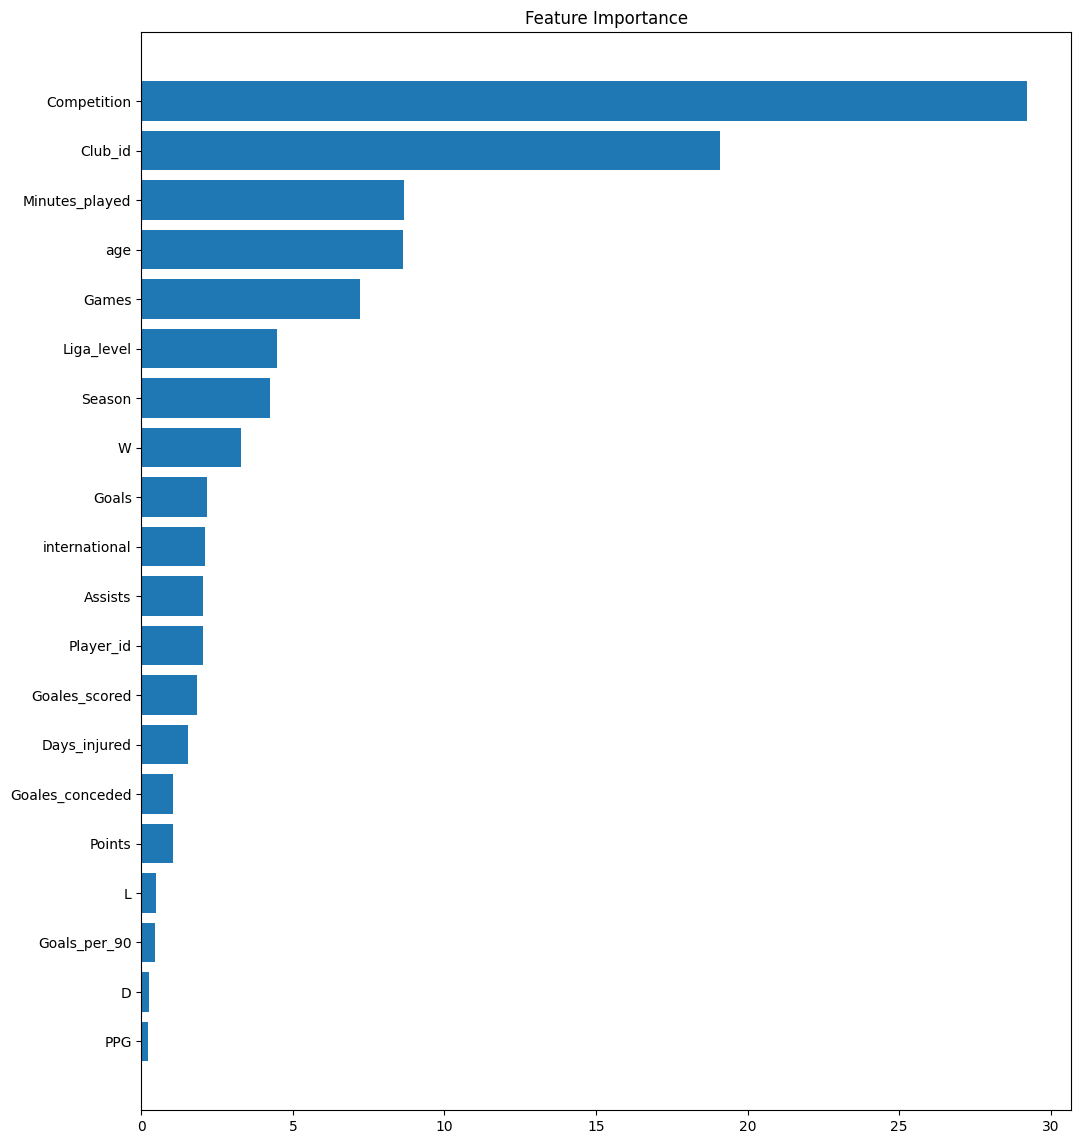

In [97]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 14))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.drop(['MarketValue'], axis = 1).columns)[sorted_idx])
plt.title('Feature Importance')

In [98]:
pred = model.predict(x_test)
pred = 10**(pred) - 1
pred[pred < 0] = pred.mean()
cat_rmsle = round(rmsle(y_test, pred), 2)
print('Test RMSLE:', cat_rmsle)

Test RMSLE: 0.73
